In [1]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"

import jax  # 导入JAX库，用于加速数值计算
import jax.numpy as jnp  # 导入JAX的NumPy子模块，用于数值计算
from jax._src import dtypes  # 导入JAX的dtypes模块，用于处理数据类型

import netket as nk  # 导入NetKet库，用于量子多体系统的模拟
from netket.experimental.driver.vmc_srt import VMC_SRt  # 导入VMC_SRt类
from netket.operator.spin import sigmax, sigmay, sigmaz

import time  # 导入time库，用于计算运行时间
import matplotlib.pyplot as plt  # 导入matplotlib库，用于绘图

In [2]:
# 设置1D晶格的参数
L = 20  # 晶格长度，即晶格中包含的节点数
J2 = 0  # 下一个最近邻相互作用的耦合常数，表示相邻节点之间的相互作用强度

# 创建1D晶格
lattice = nk.graph.Chain(length=L, pbc=True, max_neighbor_order=2)  # 创建一个长度为L的1D链式晶格，具有周期性边界条件和最大邻居顺序为2

# 创建Hilbert空间
hilbert = nk.hilbert.Spin(s=1/2, N=lattice.n_nodes, total_sz=0)  # 创建一个Hilbert空间，表示晶格上的自旋系统，具有总自旋为0的约束

# 创建Heisenberg自旋哈密顿量
hamiltonian = nk.operator.Heisenberg(hilbert=hilbert, graph=lattice, J=[1.0, J2])  # 创建一个Heisenberg自旋哈密顿量，包含最近邻和下一个最近邻的相互作用

# 使用Lanczos算法计算哈密顿量的本征值和本征向量
evals, evecs = nk.exact.lanczos_ed(hamiltonian, compute_eigenvectors=True)  

# 输出基态能量
print('The exact ground-state energy is E0 = ', evals[0] / (4 * L))  #基态能量除以四是因为netket里用的泡利矩，缺少1/2常数，两个相互作用就是1/4

# 获取基态波函数
ground_state = evecs[:, 0]

The exact ground-state energy is E0 =  -0.4452193264938236


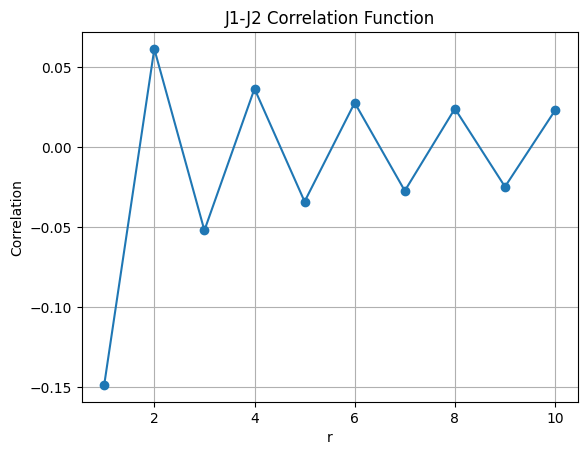

In [3]:
def correlation_function(L, r, op_constructor, hilbert, wavefunction):
    corr_op = nk.operator.LocalOperator(hilbert, 0.0)
    for i in range(L):
        j = (i + r) % L
        corr_op += op_constructor(hilbert, i) * op_constructor(hilbert, j)
    mat = corr_op.to_dense()
    return 0.25 * (wavefunction.conjugate().T @ (mat @ wavefunction)) / L

x_vals = range(1, (L // 2) + 1)
corr_vals = []
for r in x_vals:
    cval = correlation_function(L, r, sigmaz, hilbert, ground_state)
    corr_vals.append(jnp.real(cval))

plt.plot(x_vals, corr_vals, marker='o')
plt.xlabel('r')
plt.ylabel('Correlation')
plt.title('J1-J2 Correlation Function')
plt.grid(True)
plt.show()